In [13]:
import math
import time
import matplotlib.pyplot as plt
import numba
import numpy as np
from numba import cuda
import cv2

In [14]:
# Import image
img = cv2.imread('lenna.png')
img_width = img.shape[1]
img_height = img.shape[0]
print("Original image shape: ", img.shape)

Original image shape:  (512, 512, 3)


In [15]:
# Copy image to GPU
devOutput = cuda.device_array((img_height, img_width, 3), np.uint8)
devInput = cuda.to_device(img)

# Gaussian filter
gaussian_filter = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
])

# Copy filter to GPU
gaussianFilter = cuda.to_device(gaussian_filter)

In [16]:
@cuda.jit
def blur_without_shared_mem(rgb, blur, filter):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    radius = 3
    red = 0
    green = 0
    blue = 0
    kernel_sum = 0

    # Avoid out-of-range threads
    if tidx >= img_height or tidy >= img_width:
        return

    # Convolution
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            if 0 <= (tidx + i) < img_height and 0 <= (tidy + j) < img_width:
                red += rgb[tidx + i, tidy + j, 0] * filter[i + radius, j + radius]
                green += rgb[tidx + i, tidy + j, 1] * filter[i + radius, j + radius]
                blue += rgb[tidx + i, tidy + j, 2] * filter[i + radius, j + radius]
                kernel_sum += filter[i + radius, j + radius]

    blur[tidx, tidy, 0] = red / kernel_sum
    blur[tidx, tidy, 1] = green / kernel_sum
    blur[tidx, tidy, 2] = blue / kernel_sum

Without shared memory - Response time according to block size:  [0.00016832351684570312, 0.00014472007751464844, 0.0001342296600341797, 0.00011539459228515625] [(4, 4), (8, 8), (16, 16), (32, 32)]


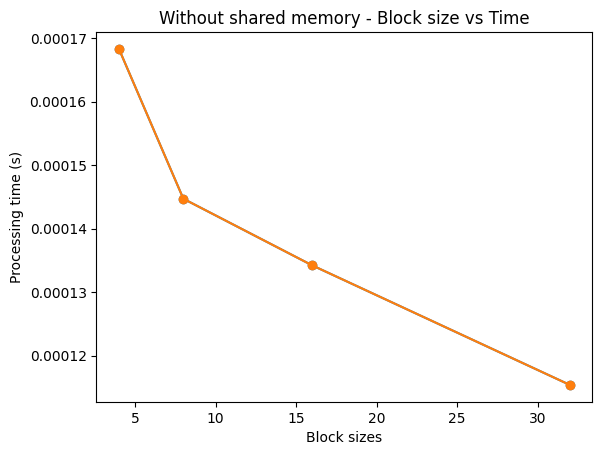

In [17]:
# First run to remove odd
blur_without_shared_mem[(math.ceil(img_height / 4), math.ceil(img_width / 4)), (4, 4)](devInput, devOutput, gaussianFilter)

blockSizes = [(4, 4), (8, 8), (16, 16), (32, 32)]
responseTimes = []
for blockSize in blockSizes:
    gridSize = (math.ceil(img_height / blockSize[0]), math.ceil(img_width / blockSize[1]))
    start_time_gpu = time.time()
    blur_without_shared_mem[gridSize, blockSize](devInput, devOutput, gaussianFilter)
    end_time_gpu = time.time()
    gpu_time = end_time_gpu - start_time_gpu
    responseTimes.append(gpu_time)

print("Without shared memory - Response time according to block size: ", responseTimes, blockSizes)
plt.figure()
plt.title("Without shared memory - Block size vs Time")
plt.xlabel("Block sizes")
plt.ylabel("Processing time (s)")
plt.plot(blockSizes, responseTimes, marker = 'o')
plt.show()

In [18]:
hostOutput = devOutput.copy_to_host()
print("hostOutput shape: ", hostOutput.shape)
hostOutput_converted = np.reshape(hostOutput, (img_width, img_height, 3))

# Show output images
cv2.imwrite(f"lenna_blur_without_shared.png", hostOutput_converted)

hostOutput shape:  (512, 512, 3)


True

In [19]:
@cuda.jit
def blur_with_shared_mem(rgb, blur, filter):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    filter_size = 7
    tile = cuda.shared.array(shape = (7, 7), dtype = numba.float32)

    local_thread_id = cuda.threadIdx.x + cuda.threadIdx.y * cuda.blockDim.x
    num_filter_elements = filter_size * filter_size
    threads_per_block = cuda.blockDim.x * cuda.blockDim.y

    for idx in range (local_thread_id, num_filter_elements, threads_per_block):
        fx = idx // filter_size
        fy = idx % filter_size
        tile[fx, fy] = filter[fx, fy]
    cuda.syncthreads()

    radius = 3
    red = 0
    green = 0
    blue = 0
    kernel_sum = 0

    # Avoid out-of-range threads
    if tidx >= img_height or tidy >= img_width:
        return

    # Convolution
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            if 0 <= (tidx + i) < img_height and 0 <= (tidy + j) < img_width:
                red += rgb[tidx + i, tidy + j, 0] * tile[i + radius, j + radius]
                green += rgb[tidx + i, tidy + j, 1] * tile[i + radius, j + radius]
                blue += rgb[tidx + i, tidy + j, 2] * tile[i + radius, j + radius]
                kernel_sum += tile[i + radius, j + radius]

    blur[tidx, tidy, 0] = red / kernel_sum
    blur[tidx, tidy, 1] = green / kernel_sum
    blur[tidx, tidy, 2] = blue / kernel_sum

With shared memory - Response time according to block size:  [0.00016188621520996094, 0.00014019012451171875, 0.0001251697540283203, 0.00010848045349121094] [(4, 4), (8, 8), (16, 16), (32, 32)]


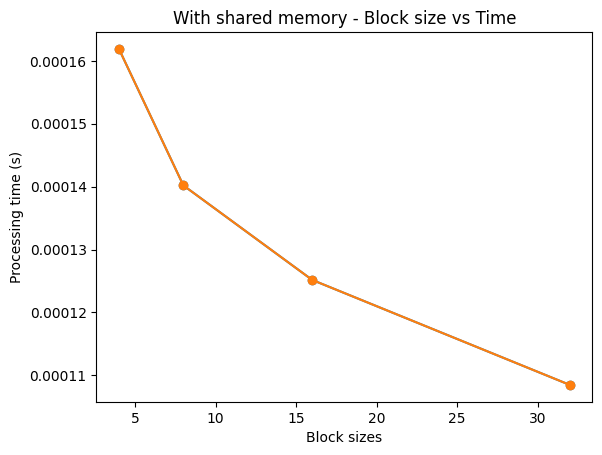

In [20]:
# First run to remove odd
blur_with_shared_mem[(math.ceil(img_height / 4), math.ceil(img_width / 4)), (4, 4)](devInput, devOutput, gaussianFilter)
blockSizes = [(4, 4), (8, 8), (16, 16), (32, 32)]
responseTimes = []
for blockSize in blockSizes:
    gridSize = (math.ceil(img_height / blockSize[0]), math.ceil(img_width / blockSize[1]))
    start_time_gpu = time.time()
    blur_with_shared_mem[gridSize, blockSize](devInput, devOutput, gaussianFilter)
    end_time_gpu = time.time()
    gpu_time = end_time_gpu - start_time_gpu
    responseTimes.append(gpu_time)

print("With shared memory - Response time according to block size: ", responseTimes, blockSizes)
plt.figure()
plt.title("With shared memory - Block size vs Time")
plt.xlabel("Block sizes")
plt.ylabel("Processing time (s)")
plt.plot(blockSizes, responseTimes, marker = 'o')
plt.show()

In [21]:
hostOutput = devOutput.copy_to_host()
print("hostOutput shape: ", hostOutput.shape)
hostOutput_converted = np.reshape(hostOutput, (img_width, img_height, 3))

# Show output images
cv2.imwrite(f"lenna_blur_with_shared.png", hostOutput_converted)

hostOutput shape:  (512, 512, 3)


True